In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.layers import Conv1D, Conv2D,Conv1D, MaxPooling1D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import ConvLSTM2D, ConvLSTM1D, Dropout, TimeDistributed
from tensorflow.keras import metrics
from tensorflow.keras import layers
from scipy.signal import butter, lfilter, sosfilt



In [2]:
print(tf.__version__)

2.10.0


In [3]:
# List all available physical devices (CPU and GPU)
physical_devices = tf.config.list_physical_devices()
print("Available devices:", physical_devices)

# List only GPU devices
gpu_devices = tf.config.list_physical_devices('GPU')
print("Available GPU devices:", gpu_devices)

if gpu_devices:
    print(f"TensorFlow detected {len(gpu_devices)} GPU(s). Training will likely use the GPU.")
    # Optional: Configure GPU memory growth to prevent allocating all memory at once
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("TensorFlow did NOT detect any GPU. Training will run on CPU.")

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow detected 1 GPU(s). Training will likely use the GPU.


In [25]:
df = pd.read_csv('D:\\DoctoralSchool\\Telepresence Toolkit\\ArmBandConnection\\Datasets\\ARM_2D1T\\Arm_Erick_00.csv')
df = df.append(pd.read_csv('D:\\DoctoralSchool\\Telepresence Toolkit\\ArmBandConnection\\Datasets\\ARM_2D1T\\Arm_Erick_03.csv'))
df = df.append(pd.read_csv('D:\\DoctoralSchool\\Telepresence Toolkit\\ArmBandConnection\\Datasets\\ARM_2D1T\\Arm_Erick_01.csv'))
df = df.append(pd.read_csv('D:\\DoctoralSchool\\Telepresence Toolkit\\ArmBandConnection\\Datasets\\ARM_2D1T\\Arm_Erick_02.csv'))
#df = df.append(pd.read_csv('D:\\Erick\\Obuda\\TelepresenceEMG\\2D_1T\\Arm_Erick_21.csv'))
df = df.append(pd.read_csv('D:\\DoctoralSchool\\Telepresence Toolkit\\ArmBandConnection\\Datasets\\ARM_2D1T\\Arm_Erick_04.csv'))

# Separate features and labels
features = df.iloc[:, :-3].values.reshape(-1,8,1000)  # All columns except the last 3 (label)
labels = df.iloc[:, -3:].values  # Last 3 columns (categorical labels)
#print(len(features[0]),len(labels)) 
print (labels.shape, features.shape)
print(labels)

(16441, 3) (16441, 8, 1000)
[[ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0. -1.]
 ...
 [ 0.  0. -1.]
 [ 0.  0. -1.]
 [ 0.  0. -1.]]


In [26]:
print(labels[435])

[ 0.99996948  0.         -1.        ]


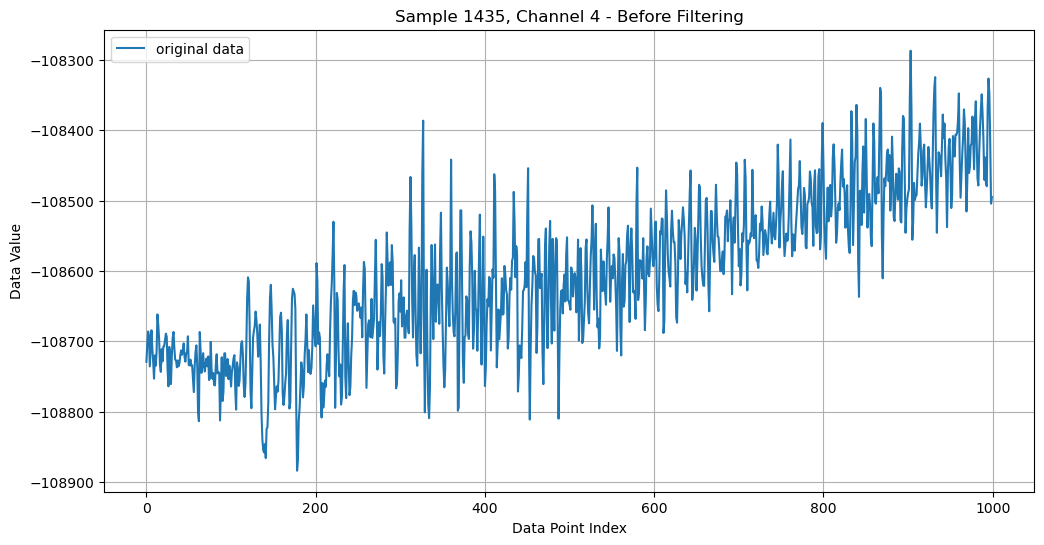

In [27]:
# --- Plotting ---
import matplotlib.pyplot as plt
# Choose a sample and a channel to plot
sample_index = 1435
channel_index = 4
sampling_rate=500
num_points=1000
time = np.linspace(0, num_points / sampling_rate, num_points, endpoint=False)
plt.figure(figsize=(12, 6))


plt.plot(time * sampling_rate, features[sample_index, channel_index, :], label='original data')
plt.title(f'Sample {sample_index}, Channel {channel_index} - Before Filtering')
plt.xlabel('Data Point Index')
plt.ylabel('Data Value')
plt.legend()
plt.grid(True)

In [28]:
sampling_rate = 500  # Replace with your actual sampling rate in Hz
cutoff_frequency = 10   # cutoff frequency in Hz (10)
low_cutoff_frequency = 10  # Lower cutoff frequency in Hz (20)
high_cutoff_frequency = 240 # Upper cutoff frequency in Hz (240)
filter_order = 4
filter_type = 'bandpass'  # Choose 'highpass', 'lowpass', 'bandpass', or 'bandstop'
nyquist_freq = 0.5 * sampling_rate
snip_points = 150

# Normalize both cutoff frequencies
normalized_low_cutoff = low_cutoff_frequency / nyquist_freq
normalized_high_cutoff = high_cutoff_frequency / nyquist_freq
normalized_cutoff = [normalized_low_cutoff, normalized_high_cutoff]
sos = butter(filter_order, normalized_cutoff, btype=filter_type, analog=False, output= 'sos')
filtered_data = np.zeros_like(features, dtype=float)
for i in range(features.shape[0]):      # Iterate through samples
    for j in range(features.shape[1]):  # Iterate through channels
        filtered_data[i, j, :] = sosfilt(sos, features[i, j, :])

        #REMOVE THE FIRST 150 DATAPOINTS TO CUT THE BOUNCING PART
cropped_filtered_data = filtered_data[:, :, snip_points:]

print("Original features shape:", features.shape)
print("Filtered data shape (before cropping):", filtered_data.shape)
print("Cropped filtered data shape:", cropped_filtered_data.shape)

Original features shape: (16441, 8, 1000)
Filtered data shape (before cropping): (16441, 8, 1000)
Cropped filtered data shape: (16441, 8, 850)


In [29]:
dc_filtered_data = []
for d in cropped_filtered_data:
    dc_filtered_data.append(d - np.mean(d))
dc_filtered_data= np.array(dc_filtered_data)
print(dc_filtered_data.shape)

(16441, 8, 850)


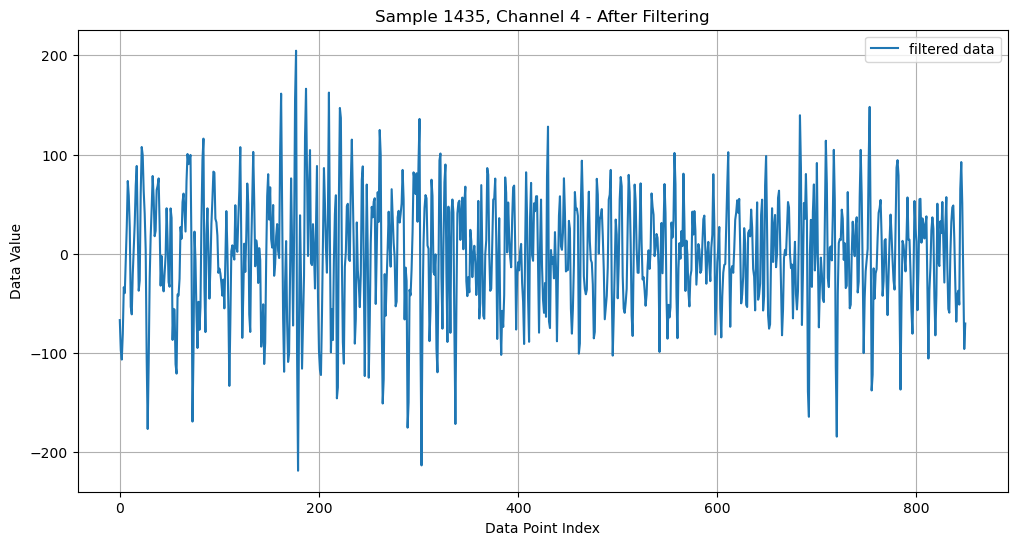

In [30]:
time = np.linspace(0, (num_points-150) / sampling_rate, num_points-150, endpoint=False)
plt.figure(figsize=(12, 6))
plt.plot((time * sampling_rate), dc_filtered_data[sample_index, channel_index, :], label='filtered data')
plt.title(f'Sample {sample_index}, Channel {channel_index} - After Filtering')
plt.xlabel('Data Point Index')
plt.ylabel('Data Value')
plt.legend()
plt.grid(True)

In [31]:
normalized_data = np.zeros_like(cropped_filtered_data, dtype=float)  # Initialize normalized array

for i in range(dc_filtered_data.shape[0]):  # Iterate through samples
    for j in range(dc_filtered_data.shape[1]):  # Iterate through channels
        channel_data = dc_filtered_data[i, j, :]  

        local_max = np.max(channel_data)
        local_min = np.min(channel_data)

        if local_max == local_min: #prevent division by zero.
            normalized_data[i, j, :] = 0.0 #set all values to zero if max and min are equal.
        else:
            normalized_data[i, j, :] = 2 * (channel_data - local_min) / (local_max - local_min) - 1
print(normalized_data.shape)

(16441, 8, 850)


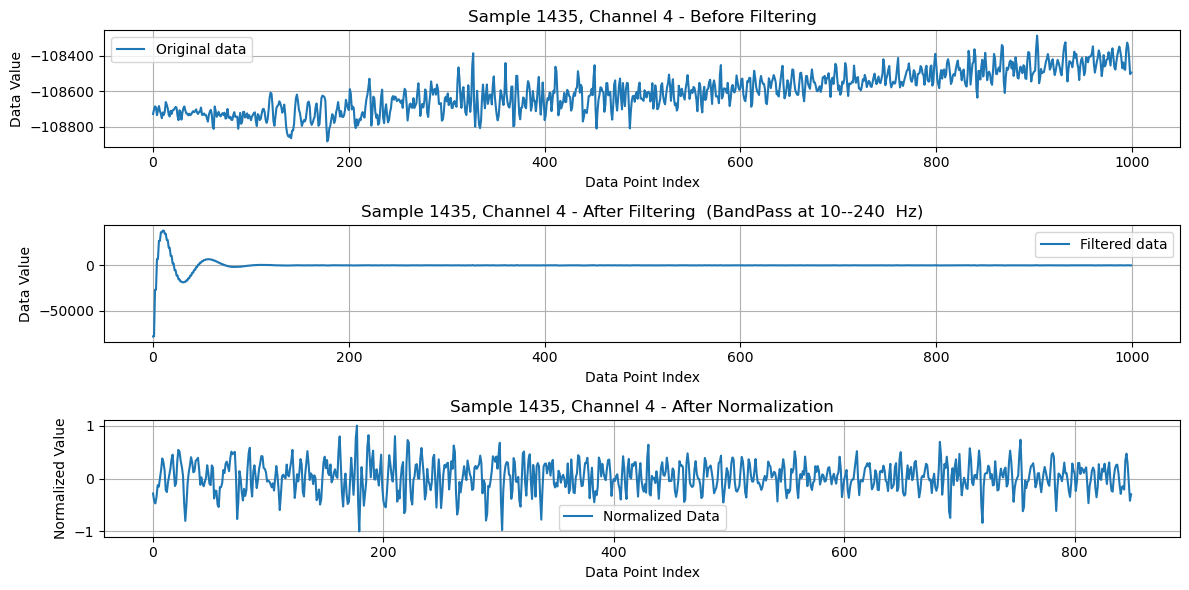

In [32]:
time = np.linspace(0, (num_points) / sampling_rate, num_points, endpoint=False)
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time * sampling_rate, features[sample_index, channel_index, :], label='Original data')
plt.title(f'Sample {sample_index}, Channel {channel_index} - Before Filtering')
plt.xlabel('Data Point Index')
plt.ylabel('Data Value')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time * sampling_rate, filtered_data[sample_index, channel_index, :], label='Filtered data')
plt.title(f'Sample {sample_index}, Channel {channel_index} - After Filtering  (BandPass at {low_cutoff_frequency }--{high_cutoff_frequency}  Hz)')
plt.xlabel('Data Point Index')
plt.ylabel('Data Value')
plt.legend()
plt.grid(True)
time = np.linspace(0, (num_points-150) / sampling_rate, num_points-150, endpoint=False)
plt.subplot(3, 1, 3)
plt.plot(time * sampling_rate, normalized_data[sample_index, channel_index, :], label='Normalized Data')
plt.title(f'Sample {sample_index}, Channel {channel_index} - After Normalization')
plt.xlabel('Data Point Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

In [33]:
def recategorize_labels_one_hot(data):
    """
    Recategorizes labels into 3 categories sets (right, left, rest) - (up, down, rest) and ( trigger, 0, 0)
    and returns them as one-hot encoded arrays.

    Args:
        data: NumPy array with shape (samples, 3), where the last 3 columns
              represent X, Y, and trigger values.

    Returns:
        NumPy array with shape (samples, 3, 3), containing the one-hot encoded labels.
    """

    num_samples = data.shape[0]
    recategorized_labels = np.zeros((num_samples,3), dtype=int)  # Initialize correctly
    print (data.shape)
    for i in range(num_samples):
        x = data[i, -3]  # X value
        y = data[i, -2]  # Y value
        trigger = data[i, -1]  # Trigger value
        #print(x,y,trigger)
        # Trigger category
        if trigger > -0.7:  # Assuming trigger > 0.5 is "on"
            recategorized_labels[i,0] = 1  # Trigger on
        else:
            recategorized_labels[i,0] = 0  # Trigger off

        # Direction category
        #if abs(x) > abs(y) and abs(x) > 0.2:  # X movement is more significant
        if x > 0.25:
            recategorized_labels[i,1] = 1  # Right
        elif x < -0.25:
            recategorized_labels[i,1] = -1  # Left
        else:  # 
            recategorized_labels[i,1] = 0  # center
           
        if y > 0.25:
            recategorized_labels[i,2] = 1  # Up
        elif y < -0.25:
            recategorized_labels[i,2] = -1  # Down
        else:
            recategorized_labels[i,2] = 0  # Center 
    #print(recategorized_labels[1435])
    #direction_labels_one_hot = to_categorical(recategorized_labels)
    return recategorized_labels #direction_labels_one_hot #recategorized_labels

In [34]:
cat_labels= recategorize_labels_one_hot(labels)
print(cat_labels.shape)
cat_labels[1435]

(16441, 3)
(16441, 3)


array([ 0, -1,  0])

In [35]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(normalized_data, cat_labels, test_size=0.2, random_state=40)

In [36]:
X_train.shape , y_train.shape, X_test.shape, y_test.shape

((13152, 8, 850), (13152, 3), (3289, 8, 850), (3289, 3))

In [37]:
# Separate directions and trigger labels
direction_horizontal_train = y_train[:, 1].reshape((-1, 1))  # Shape: (batch, 1)
direction_vertical_train = y_train[:, 2].reshape((-1, 1))  # Shape: (batch, 1)
trigger_label_train = y_train[:, 0].reshape((-1, 1))  # Shape: (batch, 1)

direction_horizontal_test = y_test[:, 1].reshape((-1, 1))  # Shape: (batch, 3)
direction_vertical_test = y_test[:, 2].reshape((-1, 1))  # Shape: (batch, 3)
trigger_label_test = y_test[:, 0].reshape((-1, 1))  # Shape: (batch, 1)
print(direction_horizontal_train.shape, trigger_label_train.shape, direction_horizontal_test.shape, trigger_label_test.shape)

(13152, 1) (13152, 1) (3289, 1) (3289, 1)


In [38]:
trigger_label_train, direction_horizontal_train

(array([[1],
        [0],
        [1],
        ...,
        [0],
        [0],
        [1]]),
 array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]))

In [74]:
# Define the model.
from tensorflow.keras import regularizers
from tensorflow import keras 
from tensorflow.keras.layers import Layer


reg=0.00001
input_layer = Input(shape=(8,850))
#x = tf.keras.layers.Permute ((2,1))(input_layer)
#x = input_layer.reshape((-1, 8, 850, 1))
#x = Conv2D(filters=200, kernel_size=(10,8), padding='same', activation='relu',data_format = 'channels_last', kernel_regularizer=regularizers.l2(reg))(x)#, input_shape=(n_channels, steps)
#print(x.shape)
#x = MaxPooling2D(pool_size=(8,10), data_format = 'channels_last')(x)
#print(x.shape)
x = keras.layers.Reshape(( 1, 8,850,1))(input_layer)
print(x.shape)
x = ConvLSTM2D(filters=150, kernel_size=(8,10), activation='elu', padding='same')(x)
print(x.shape)
x = MaxPooling2D(pool_size=(8,10), data_format = 'channels_last')(x)
print(x.shape)
x = keras.layers.Reshape(( 1, 85,150,1))(x)
x = ConvLSTM2D(filters=50, kernel_size=(8,10), activation='elu', padding='same')(x)
print(x.shape)
x = MaxPooling2D(pool_size=(8,10), data_format = 'channels_last')(x)
print(x.shape)
x = keras.layers.Reshape((1*10*15*50,))(x)
print(x.shape)
direction_horizontal = Dense(units=10,kernel_regularizer=regularizers.l2(reg), activation='softmax')(x)
direction_vertical = Dense(units=10,kernel_regularizer=regularizers.l2(reg), activation='softmax')(x)
trigger_output = Dense(units=10,kernel_regularizer=regularizers.l2(reg), activation='sigmoid')(x)
print(direction_horizontal.shape)
#direction_horizontal = Dense(units=10, activation='softmax',kernel_regularizer=regularizers.l2(reg))(direction_horizontal)
#direction_vertical = Dense(units=10, activation='softmax',kernel_regularizer=regularizers.l2(reg))(direction_vertical)
#trigger_output = Dense(units=10, activation='sigmoid',kernel_regularizer=regularizers.l2(reg))(trigger_output)

horizontal_output = Dense(units=1, activation='softmax',kernel_regularizer=regularizers.l2(reg), name='horizontal')(direction_horizontal)
vertical_output = Dense(units=1, activation='softmax',kernel_regularizer=regularizers.l2(reg), name='vertical')(direction_vertical)
trigger_out = Dense(units=1, activation='sigmoid',kernel_regularizer=regularizers.l2(reg), name='trigger')(trigger_output)
print(horizontal_output.shape)
model2 = Model(inputs=input_layer, outputs=[horizontal_output, vertical_output, trigger_out])


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10,
    decay_rate=0.98
    )

#lossWeights = {"horizontal": 1.0,"vertical": 1.0, "trigger": 1.0}


# COMPARE OPTIMIZERS IN ARTICLE
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model2.compile(optimizer=opt,
          loss={'horizontal': 'categorical_crossentropy', 'vertical': 'categorical_crossentropy', 'trigger' :'binary_crossentropy'},
          #metrics=['mae','accuracy']
          metrics={'horizontal': ['accuracy', metrics.AUC(), metrics.Precision()],'vertical': ['accuracy', metrics.AUC(), metrics.Precision()],'trigger': ['accuracy', metrics.AUC(), metrics.Precision()]}
        ) 
history2= model2.fit(X_train, {'horizontal': direction_horizontal_train, 'vertical': direction_vertical_train, 'trigger': trigger_label_train},
                   epochs=10, batch_size=25,
                   validation_data=(X_test, {'horizontal': direction_horizontal_test, 'vertical': direction_vertical_test, 'trigger': trigger_label_test}))

(None, 1, 8, 850, 1)
(None, 8, 850, 150)
(None, 1, 85, 150)
(None, 85, 150, 50)
(None, 10, 15, 50)
(None, 7500)
(None, 10)
(None, 3)
Epoch 1/10
385/385 [==============================] - 926s 2s/step - loss: 2.6435 - horizontal_loss: 0.9798 - vertical_loss: 0.9836 - trigger_loss: 0.6792 - horizontal_accuracy: 0.6209 - horizontal_auc_18: 0.7104 - horizontal_precision_18: 0.6139 - vertical_accuracy: 0.6023 - vertical_auc_19: 0.7571 - vertical_precision_19: 0.0000e+00 - trigger_accuracy: 0.5493 - trigger_auc_20: 0.6331 - trigger_precision_20: 1.0000 - val_loss: 2.5209 - val_horizontal_loss: 0.9475 - val_vertical_loss: 0.9254 - val_trigger_loss: 0.6470 - val_horizontal_accuracy: 0.6230 - val_horizontal_auc_18: 0.7139 - val_horizontal_precision_18: 0.6230 - val_vertical_accuracy: 0.7249 - val_vertical_auc_19: 0.8279 - val_vertical_precision_19: 0.0000e+00 - val_trigger_accuracy: 0.5539 - val_trigger_auc_20: 0.7808 - val_trigger_precision_20: 0.9429
Epoch 2/10
385/385 [======================

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Define constants based on your input data
# N will be the batch size, which is dynamic
NUM_CHANNELS = 8
TIME_STEPS = 850 # Or the length of your sequence
NUM_CLASSES_VERTICAL = 1 # Example: Up, Down, None
NUM_CLASSES_HORIZONTAL = 1 # Example: Left, Right, None
NUM_CLASSES_FIST = 1 # Example: Fist (1), No Fist (0) - binary classification

def build_cnn_lstm_model(reg_strength=0.0001, dropout_rate=0.2):
    """
    Builds a multi-output CNN-LSTM model for EMG classification.

    Args:
        reg_strength (float): L2 regularization strength.
        dropout_rate (float): Dropout rate for regularization.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """

    # Input Layer: (Batch_size, NUM_CHANNELS, TIME_STEPS)
    input_layer = keras.Input(shape=(NUM_CHANNELS, TIME_STEPS), name='emg_input')

    # --- Reshape for Conv2D ---
    # Conv2D expects (batch, height, width, channels) or (batch, channels, height, width)
    # We want to treat channels (8) as height, time_steps (850) as width, and add a '1' for features
    # So, we reshape (B, 8, 850) to (B, 8, 850, 1)
    x = layers.Reshape((NUM_CHANNELS, TIME_STEPS, 1), name='reshape_for_conv2d')(input_layer)

    # --- Convolutional Layers for Feature Extraction ---
    # These layers learn spatial patterns across channels and local temporal patterns.
    # Conv2D: Apply filters to learn features.
    # Using 'same' padding to maintain input dimensions for subsequent pooling.
    # We'll apply pooling along the time dimension primarily.

    x = layers.Conv2D(
        filters=64, # Number of filters/feature maps
        kernel_size=(NUM_CHANNELS, 10), # Kernel spans all 8 channels, and 10 time steps
        padding='same', # Output feature map size is same as input (after considering strides)
        activation='relu', # Rectified Linear Unit activation
        kernel_regularizer=regularizers.l2(reg_strength),
        name='conv2d_1'
    )(x)
    x = layers.BatchNormalization(name='batchnorm_1')(x) # Helps stabilize training
    x = layers.MaxPooling2D(
        pool_size=(1, 5), # Pool across 5 time steps, keeping channel dimension as is
        padding='same',
        name='maxpool2d_1'
    )(x)
    x = layers.Dropout(dropout_rate, name='dropout_conv_1')(x)

    x = layers.Conv2D(
        filters=128, # More filters to learn more complex features
        kernel_size=(1, 5), # Kernel spans 1 channel, 5 time steps - focuses purely on temporal patterns
        padding='same',
        activation='relu',
        kernel_regularizer=regularizers.l2(reg_strength),
        name='conv2d_2'
    )(x)
    x = layers.BatchNormalization(name='batchnorm_2')(x)
    x = layers.MaxPooling2D(
        pool_size=(1, 5), # Further reduce time dimension
        padding='same',
        name='maxpool2d_2'
    )(x)
    x = layers.Dropout(dropout_rate, name='dropout_conv_2')(x)

    # --- Flatten / Reshape for LSTM ---
    # After Conv2D and MaxPooling, we have a 4D tensor (Batch, Channels_after_conv, Time_after_pool, Filters)
    # For LSTM, we need a 3D tensor (Batch, Time_steps, Features)
    # We'll flatten the channels and filters into the 'features' dimension for LSTM.
    # First, let's get the current shape after pooling to calculate the new feature dimension.
    # The output shape of maxpool2d_2 will be (B, 8, 850, 128) -> after pooling (B, 8, 850/25, 128) approx (B, 8, 34, 128) if using fixed pools
    # Let's verify the `pool_size` and `padding='same'` with input_length=850
    # First pool (1,5): 850 / 5 = 170. Shape: (B, 8, 170, 64)
    # Second pool (1,5): 170 / 5 = 34. Shape: (B, 8, 34, 128)

    # Now flatten the last two dimensions to be the features for LSTM
    # (Batch, 8, 34, 128) -> (Batch, 34, 8 * 128) = (Batch, 34, 1024)
    pre_lstm_shape = x.shape[1] * x.shape[3] # Calculate 8 * 128 = 1024
    x = layers.Reshape((x.shape[2], pre_lstm_shape), name='reshape_for_lstm')(x) # (Batch, 34, 1024)

    # --- LSTM Layers for Temporal Pattern Recognition ---
    # LSTMs are good at capturing long-range dependencies in sequences.
    x = layers.LSTM(
        units=128, # Number of LSTM units
        return_sequences=True, # Return sequences for stacking another LSTM
        kernel_regularizer=regularizers.l2(reg_strength),
        dropout=dropout_rate,
        name='lstm_1'
    )(x)
    x = layers.BatchNormalization(name='batchnorm_lstm_1')(x)
    x = layers.LSTM(
        units=64, # Fewer units for the second LSTM
        return_sequences=False, # Only return the final output for the dense layers
        kernel_regularizer=regularizers.l2(reg_strength),
        dropout=dropout_rate,
        name='lstm_2'
    )(x)
    x = layers.BatchNormalization(name='batchnorm_lstm_2')(x) # Batch norm after LSTM often helps
    x = layers.Dropout(dropout_rate, name='dropout_final')(x) # Final dropout before dense layers

    # --- Common Dense Layer (Feature Bottleneck) ---
    # A shared dense layer to process features before branching to output heads.
    # This helps the model learn a concise representation relevant to all tasks.
    shared_features = layers.Dense(
        units=64, # Number of neurons in the shared dense layer
        activation='relu', # ReLU is common for intermediate dense layers
        kernel_regularizer=regularizers.l2(reg_strength),
        name='shared_dense'
    )(x)

    # --- Output Branches ---
    # Each output has its own Dense layer with appropriate activation and name.

    # 1. Vertical Rotation Classification
    # Use softmax for multi-class classification
    vertical_output = layers.Dense(
        units=NUM_CLASSES_VERTICAL, # e.g., 3 classes (Up, Down, None)
        activation='tanh',
        name='vertical_rotation'
    )(shared_features)

    # 2. Horizontal Rotation Classification
    # Use softmax for multi-class classification
    horizontal_output = layers.Dense(
        units=NUM_CLASSES_HORIZONTAL, # e.g., 3 classes (Left, Right, None)
        activation='tanh',
        name='horizontal_rotation'
    )(shared_features)

    # 3. Fist Activity Classification
    # Use sigmoid for binary classification (Fist or No Fist)
    fist_output = layers.Dense(
        units=NUM_CLASSES_FIST, # Use 1 for binary_crossentropy
        activation='sigmoid',
        name='fist_activity'
    )(shared_features)

    # --- Create the Model ---
    # Define the inputs and all outputs
    model = keras.Model(
        inputs=input_layer,
        outputs=[vertical_output, horizontal_output, fist_output],
        name='emg_multi_task_cnn_lstm_model'
    )

    # --- Compile the Model ---
    # Define the optimizer, and a dictionary of loss functions and metrics for each output.
    model.compile(
        optimizer='adam', # Adam optimizer is a good default
        loss={
            'vertical_rotation': 'mae',
            'horizontal_rotation': 'mae',
            'fist_activity': 'mae'
        },
        metrics={
            'vertical_rotation': ['accuracy', metrics.AUC(name='auc'), metrics.Precision(name='precision')],
            'horizontal_rotation': ['accuracy', metrics.AUC(name='auc'), metrics.Precision(name='precision')],
            'fist_activity': ['accuracy', metrics.AUC(name='auc'), metrics.Precision(name='precision')]
        }
    )

    return model

model = build_cnn_lstm_model()

    # To train the model, you would typicall
history = model.fit( X_train,
          {'horizontal_rotation': direction_horizontal_train, 'vertical_rotation': direction_vertical_train, 'fist_activity': trigger_label_train},
          epochs=40,
          batch_size=100,
          validation_data=(X_test, {'horizontal_rotation': direction_horizontal_test, 'vertical_rotation': direction_vertical_test, 'fist_activity': trigger_label_test})
          #callbacks=[...]
         )

Epoch 1/40
132/132 [==============================] - 17s 94ms/step - loss: 1.3068 - vertical_rotation_loss: 0.4361 - horizontal_rotation_loss: 0.5455 - fist_activity_loss: 0.2223 - vertical_rotation_accuracy: 0.6442 - vertical_rotation_auc: 0.4518 - vertical_rotation_precision: 0.3036 - horizontal_rotation_accuracy: 0.5889 - horizontal_rotation_auc: 0.5237 - horizontal_rotation_precision: 0.4463 - fist_activity_accuracy: 0.8038 - fist_activity_auc: 0.8766 - fist_activity_precision: 0.7705 - val_loss: 1.4524 - val_vertical_rotation_loss: 0.4426 - val_horizontal_rotation_loss: 0.4466 - val_fist_activity_loss: 0.4593 - val_vertical_rotation_accuracy: 0.6914 - val_vertical_rotation_auc: 0.5000 - val_vertical_rotation_precision: 0.0000e+00 - val_horizontal_rotation_accuracy: 0.6397 - val_horizontal_rotation_auc: 0.5952 - val_horizontal_rotation_precision: 0.0000e+00 - val_fist_activity_accuracy: 0.5363 - val_fist_activity_auc: 0.8083 - val_fist_activity_precision: 0.0000e+00
Epoch 2/40
132

132/132 [==============================] - 11s 84ms/step - loss: 0.3098 - vertical_rotation_loss: 0.0772 - horizontal_rotation_loss: 0.1242 - fist_activity_loss: 0.0171 - vertical_rotation_accuracy: 0.8276 - vertical_rotation_auc: 0.6388 - vertical_rotation_precision: 0.9459 - horizontal_rotation_accuracy: 0.7864 - horizontal_rotation_auc: 0.6289 - horizontal_rotation_precision: 0.9472 - fist_activity_accuracy: 0.9846 - fist_activity_auc: 0.9930 - fist_activity_precision: 0.9753 - val_loss: 0.2646 - val_vertical_rotation_loss: 0.0521 - val_horizontal_rotation_loss: 0.1107 - val_fist_activity_loss: 0.0114 - val_vertical_rotation_accuracy: 0.8337 - val_vertical_rotation_auc: 0.7320 - val_vertical_rotation_precision: 0.9286 - val_horizontal_rotation_accuracy: 0.7893 - val_horizontal_rotation_auc: 0.6966 - val_horizontal_rotation_precision: 0.8968 - val_fist_activity_accuracy: 0.9894 - val_fist_activity_auc: 0.9950 - val_fist_activity_precision: 0.9806
Epoch 10/40
132/132 [================

132/132 [==============================] - 11s 86ms/step - loss: 0.1986 - vertical_rotation_loss: 0.0425 - horizontal_rotation_loss: 0.0674 - fist_activity_loss: 0.0106 - vertical_rotation_accuracy: 0.8391 - vertical_rotation_auc: 0.6617 - vertical_rotation_precision: 0.9736 - horizontal_rotation_accuracy: 0.7963 - horizontal_rotation_auc: 0.6393 - horizontal_rotation_precision: 0.9726 - fist_activity_accuracy: 0.9898 - fist_activity_auc: 0.9942 - fist_activity_precision: 0.9856 - val_loss: 0.1984 - val_vertical_rotation_loss: 0.0450 - val_horizontal_rotation_loss: 0.0701 - val_fist_activity_loss: 0.0058 - val_vertical_rotation_accuracy: 0.8358 - val_vertical_rotation_auc: 0.6613 - val_vertical_rotation_precision: 0.9817 - val_horizontal_rotation_accuracy: 0.8015 - val_horizontal_rotation_auc: 0.6961 - val_horizontal_rotation_precision: 0.9908 - val_fist_activity_accuracy: 0.9951 - val_fist_activity_auc: 0.9963 - val_fist_activity_precision: 0.9948
Epoch 18/40
132/132 [================

132/132 [==============================] - 12s 89ms/step - loss: 0.1645 - vertical_rotation_loss: 0.0318 - horizontal_rotation_loss: 0.0496 - fist_activity_loss: 0.0082 - vertical_rotation_accuracy: 0.8423 - vertical_rotation_auc: 0.6765 - vertical_rotation_precision: 0.9778 - horizontal_rotation_accuracy: 0.7992 - horizontal_rotation_auc: 0.6563 - horizontal_rotation_precision: 0.9778 - fist_activity_accuracy: 0.9922 - fist_activity_auc: 0.9949 - fist_activity_precision: 0.9901 - val_loss: 0.1875 - val_vertical_rotation_loss: 0.0434 - val_horizontal_rotation_loss: 0.0586 - val_fist_activity_loss: 0.0108 - val_vertical_rotation_accuracy: 0.8361 - val_vertical_rotation_auc: 0.5684 - val_vertical_rotation_precision: 0.9075 - val_horizontal_rotation_accuracy: 0.7872 - val_horizontal_rotation_auc: 0.6582 - val_horizontal_rotation_precision: 0.8892 - val_fist_activity_accuracy: 0.9897 - val_fist_activity_auc: 0.9941 - val_fist_activity_precision: 0.9800
Epoch 26/40
132/132 [================

132/132 [==============================] - 11s 86ms/step - loss: 0.1629 - vertical_rotation_loss: 0.0298 - horizontal_rotation_loss: 0.0447 - fist_activity_loss: 0.0075 - vertical_rotation_accuracy: 0.8434 - vertical_rotation_auc: 0.6776 - vertical_rotation_precision: 0.9747 - horizontal_rotation_accuracy: 0.8006 - horizontal_rotation_auc: 0.6577 - horizontal_rotation_precision: 0.9804 - fist_activity_accuracy: 0.9929 - fist_activity_auc: 0.9954 - fist_activity_precision: 0.9907 - val_loss: 0.1492 - val_vertical_rotation_loss: 0.0264 - val_horizontal_rotation_loss: 0.0345 - val_fist_activity_loss: 0.0075 - val_vertical_rotation_accuracy: 0.8474 - val_vertical_rotation_auc: 0.6560 - val_vertical_rotation_precision: 0.9724 - val_horizontal_rotation_accuracy: 0.8054 - val_horizontal_rotation_auc: 0.6804 - val_horizontal_rotation_precision: 0.9823 - val_fist_activity_accuracy: 0.9924 - val_fist_activity_auc: 0.9959 - val_fist_activity_precision: 0.9864
Epoch 34/40
132/132 [================

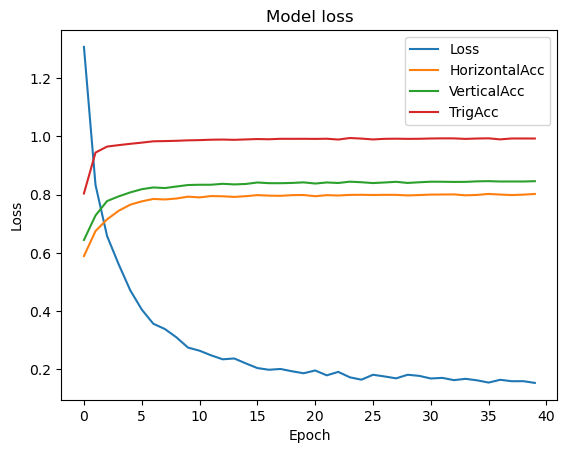

In [42]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['horizontal_rotation_accuracy'])
plt.plot(history.history['vertical_rotation_accuracy'])
plt.plot(history.history['fist_activity_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'HorizontalAcc', 'VerticalAcc','TrigAcc'], loc='upper right')S

plt.show()

In [43]:
#model2.save('D:\\Erick\\Obuda\\TelepresenceEMG\\Models\\convLSTM2D_model_01.h5')
#model2.save('D:\\Erick\\Obuda\\TelepresenceEMG\\Models\\convLSTM2D_model_01.keras')
model.save('D:\DoctoralSchool\Telepresence Toolkit\ArmBandConnection\Models\LSTM_model_04.h5')
model.save('D:\DoctoralSchool\Telepresence Toolkit\ArmBandConnection\Models\LSTM_model_04.keras')

In [ ]:
model.summary()